# Momento de Retroalimentación - Módulo 1: Utilización, procesamiento y visualización de grandes volúmenes de datos

*Adrián Galván Díaz*

*A01704076*

# Introducción

En este proyecto se exploró la utilización de herramientas de Big Data y Machine Learning aplicadas a un conjunto de datos de gran volumen, en este caso, una base de datos de 1.24 GB con imágenes de radiografías de pecho (provenientes de Kaggle), que distingue entre casos de neumonía y radiografías normales. La tarea se centra en el procesamiento y clasificación de estas imágenes con PySpark y MLlib en Google Colab.

PySpark, la interfaz de Python para Apache Spark, permite el procesamiento distribuido de datos en grandes volúmenes, facilitando la creación y entrenamiento de modelos de Machine Learning a través de MLlib, una librería integrada para el aprendizaje automático en Spark. Este trabajo busca clasificar imágenes de radiografías en dos categorías mediante un modelo de regresión logística, y a través de Tableau se desarrollaron diferentes visualizaciones para la interpretación de resultados y entendimiento de los datos.

Referencia al link de kaggle de los datos

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download



# Configuración del Entorno de Trabajo en Colab
Para empezar, configuramos el entorno de trabajo en Colab para soportar Spark, permitiendo el procesamiento distribuido necesario para manejar eficientemente este conjunto de datos masivo.

Esta instalación de Spark incluye Apache Hadoop para gestionar el almacenamiento distribuido y se configura con la versión de Java compatible con PySpark en Colab. La versión de Spark utilizada es la 3.5.3, optimizada para trabajar con herramientas de big data y procesamiento paralelo en grandes volúmenes de datos.

La instalación de las bibliotecas findspark y pyspark permite la inicialización de Spark en Google Colab. Estas variables (SPARK_HOME y JAVA_HOME) son esenciales para indicar la ubicación de las instalaciones de Spark y Java, asegurando que PySpark pueda aprovechar la capacidad de procesamiento paralelo de Spark.

In [ ]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Actualiza la versión a la más reciente de Spark (3.5.3)
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
# Extraer la nueva versión
!tar -xzf spark-3.5.3-bin-hadoop3.tgz

#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,163 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,397 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restrict

'/content/spark-3.5.3-bin-hadoop3'

# Inicialización de Spark
A continuación, creamos una sesión de Spark, definiendo parámetros específicos de memoria para optimizar el procesamiento de este conjunto de datos voluminoso.

Aquí, SparkSession se inicializa como una sesión llamada "ChestXrayClassification", reservando 15 GB de memoria para el controlador y el ejecutor de Spark. Esta asignación optimiza el procesamiento de datos intensivo, esencial para manejar el volumen y las complejidades de los datos de imagen.

In [ ]:
!pip install opencv-python-headless

La librería opencv-python-headless es una versión de OpenCV optimizada para entornos de procesamiento sin interfaz gráfica. Dado que Google Colab no necesita visualizar imágenes directamente, opencv-python-headless permite trabajar con funciones de procesamiento de imágenes sin la sobrecarga de los componentes de visualización.

In [ ]:
import cv2
import numpy as np
import os
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
import random
import matplotlib.pyplot as plt

#Inicialización de Spark
def init_spark():
    spark = SparkSession.builder \
        .appName("ChestXrayClassification") \
        .config("spark.driver.memory", "15g") \
        .config("spark.executor.memory", "15g") \
        .getOrCreate()
    return spark

spark = init_spark()
print("Sesión Spark inicializada")

Sesión Spark inicializada


# Montaje de Google Drive
Este paso permite el acceso directo a los datos almacenados en Google Drive, específicamente a la carpeta chest_xray, que contiene las subcarpetas de imágenes organizadas en categorías (Normal y Pneumonia). Esto facilita la manipulación y el preprocesamiento de las imágenes en el entorno de Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta a la carpeta principal en Google Drive
base_dir = '/content/drive/MyDrive/chest_xray/'

Mounted at /content/drive


# Análisis Exploratorio de Datos

Antes de comenzar con la creación del modelo me gustaría comenzar con un breve análisis exploratorio de datos para visualizar cómo se componen nuestros datos y tal vez obtener hipótesis o una idea para nuestro modelo de regresión.


El conjunto de datos de radiografías de pecho que vamos a analizar tiene 5,863 imágenes en formato JPEG y está organizado en tres carpetas: entrenamiento, prueba y validación, con subcarpetas para cada categoría de imágenes (Neumonía/Normal). Las imágenes de rayos X (vista anteroposterior) fueron seleccionadas de cohortes retrospectivas de pacientes pediátricos de uno a cinco años de edad en el Centro Médico de Mujeres y Niños de Guangzhou, en China. La toma de radiografías formó parte del cuidado clínico rutinario de los pacientes. Para asegurar la calidad, todas las radiografías fueron evaluadas para eliminar imágenes de baja calidad o ilegibles. La clasificación fue realizada por dos médicos expertos, y un tercer experto revisó el conjunto de evaluación para verificar la precisión.

Para comprender un poco más nuestra naturaleza de los datos podemos hacer un par de visualizaciones acerca de las diferencias en las radiografrías. Para ello creamos una función que nos permite hacer visualizaciones de las radiografías.

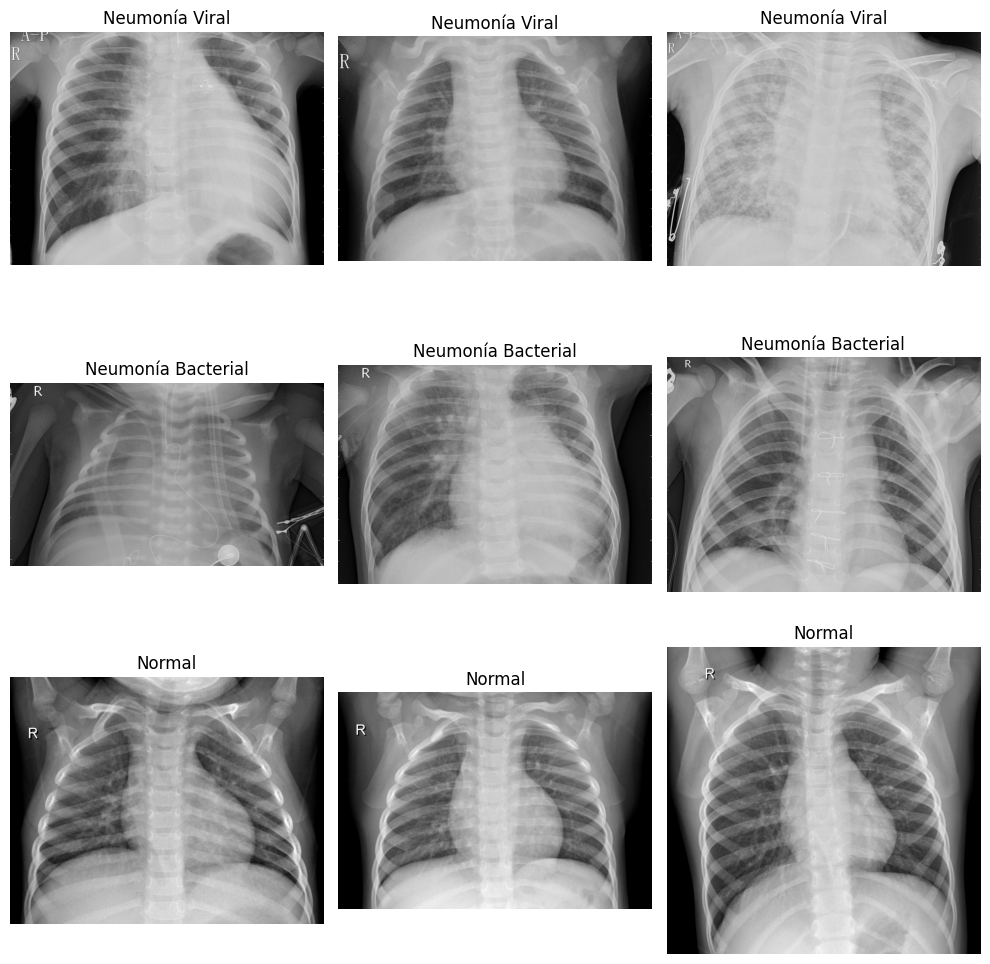

In [ ]:
def get_random_images(subfolder, keyword=None, num_images=3):
    """
    Función para obtener una ruta de imagen aleatoria dada una subcarpeta y un keyword opcional.
    Solo seleccionará imágenes que contengan el keyword en su nombre de archivo si se proporciona.
    """
    folder_path = os.path.join(base_dir, subfolder)
    if keyword:
        images = [img for img in os.listdir(folder_path) if img.endswith('.jpeg') and keyword in img.lower()]
    else:
        images = [img for img in os.listdir(folder_path) if img.endswith('.jpeg')]

    selected_images = random.sample(images, num_images)
    return [os.path.join(folder_path, img) for img in selected_images]

# Obtener rutas de imágenes aleatorias
viral_image_paths = get_random_images('train/PNEUMONIA', 'virus', 3)
bacterial_image_paths = get_random_images('train/PNEUMONIA', 'bacteria', 3)
normal_image_paths = get_random_images('train/NORMAL', num_images=3)

# Crear el subplot
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Mostrar imágenes de neumonía viral en la primera fila
for i, img_path in enumerate(viral_image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[0, i].imshow(img)
    axs[0, i].set_title("Neumonía Viral")
    axs[0, i].axis('off')  # Ocultar ejes

# Mostrar imágenes de neumonía bacterial en la segunda fila
for i, img_path in enumerate(bacterial_image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[1, i].imshow(img)
    axs[1, i].set_title("Neumonía Bacterial")
    axs[1, i].axis('off')  # Ocultar ejes

# Mostrar imágenes normales en la tercera fila
for i, img_path in enumerate(normal_image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[2, i].imshow(img)
    axs[2, i].set_title("Normal")
    axs[2, i].axis('off')  # Ocultar ejes

# Mostrar el subplot
plt.tight_layout()
plt.show()

Imágenes de Neumonía Viral:

Las imágenes de esta categoría parecen tener ciertas áreas que son más "borrosas" o con una especie de "niebla" en comparación con las imágenes normales. Estas manchas no están muy bien definidas, parecen difusas y distribuidas de manera desigual.

Imágenes de Neumonía Bacterial:

Las imágenes de neumonía bacterial tienen "manchas" o áreas densas que parecen más concentradas en zonas específicas, como si se agruparan en un solo lugar a diferencia de las imágenes de neumonía viral que parece como área fogosa distribuida en ambos pulmones. Las áreas afectadas son más claras lo que podría indicar que algo está llenando o obstruyendo esa parte del pulmón.

Imágenes Normales:

En las imágenes normales, los pulmones se ven mucho más "limpios" en comparación con las otras categorías, el "color" negro se ve uniforme a través de ambos pulmones. Los pulmones parecen tener una textura homogénea.
Las estructuras internas, como los huesos y las costillas, se ven claramente y sin obstrucciones dentro del área del pulmón a diferencia de ambas pulmonías donde es más complicado ver los huesos.

## Conteo de imágenes por sub carpeta

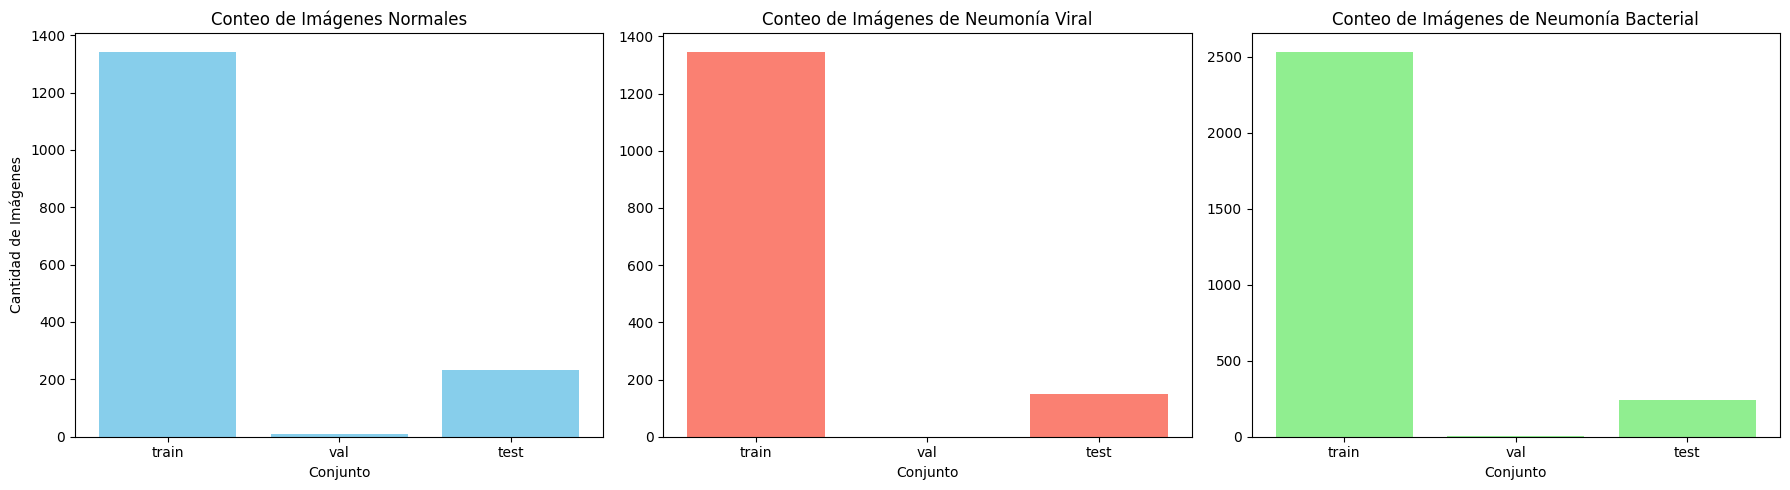

In [ ]:
def count_images(subfolder, keyword=None):
    """
    Función para contar las imágenes en una subcarpeta, opcionalmente filtrando por un keyword en el nombre.
    """
    folder_path = os.path.join(base_dir, subfolder)
    if keyword:
        images = [img for img in os.listdir(folder_path) if img.endswith('.jpeg') and keyword in img.lower()]
    else:
        images = [img for img in os.listdir(folder_path) if img.endswith('.jpeg')]
    return len(images)

# Contar imágenes en cada categoría y conjunto
counts = {
    'Normal': {
        'train': count_images('train/NORMAL'),
        'val': count_images('val/NORMAL'),
        'test': count_images('test/NORMAL')
    },
    'Neumonía Viral': {
        'train': count_images('train/PNEUMONIA', 'virus'),
        'val': count_images('val/PNEUMONIA', 'virus'),
        'test': count_images('test/PNEUMONIA', 'virus')
    },
    'Neumonía Bacterial': {
        'train': count_images('train/PNEUMONIA', 'bacteria'),
        'val': count_images('val/PNEUMONIA', 'bacteria'),
        'test': count_images('test/PNEUMONIA', 'bacteria')
    }
}

# Crear subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sets = ['train', 'val', 'test']

# Gráfico para imágenes normales
axs[0].bar(sets, [counts['Normal'][s] for s in sets], color='skyblue')
axs[0].set_title('Conteo de Imágenes Normales')
axs[0].set_xlabel('Conjunto')
axs[0].set_ylabel('Cantidad de Imágenes')

# Gráfico para imágenes de neumonía viral
axs[1].bar(sets, [counts['Neumonía Viral'][s] for s in sets], color='salmon')
axs[1].set_title('Conteo de Imágenes de Neumonía Viral')
axs[1].set_xlabel('Conjunto')

# Gráfico para imágenes de neumonía bacterial
axs[2].bar(sets, [counts['Neumonía Bacterial'][s] for s in sets], color='lightgreen')
axs[2].set_title('Conteo de Imágenes de Neumonía Bacterial')
axs[2].set_xlabel('Conjunto')

plt.tight_layout()
plt.show()

Análisis de distribución de clases:
Verde = Neumonía Bacterial
Naranja = Neumoría Viral
Azul = Normal

En las categorías de "Neumonía Viral" y "Neumonía Bacterial", el número de imágenes en el conjunto de entrenamiento es significativamente mayor que en los conjuntos de validación y prueba. Además, la categoría de "Neumonía Bacterial" tiene un número considerablemente mayor de imágenes en comparación con "Normal" y "Neumonía Viral" en todos los conjuntos. Este desbalance puede hacer que el modelo se incline a clasificar más fácilmente las imágenes en la categoría mayoritaria (en este caso, "Neumonía Bacterial") debido a la mayor cantidad de ejemplos disponibles para el entrenamiento. Esto podría causar un sesgo en el modelo, haciendo que tenga una precisión más baja en las clases minoritarias. Sin embargo, un mayor número de ejemplos en la categoría "Neumonía Bacterial" podría permitir que el modelo aprenda mejor los patrones específicos de esta clase.

# Extracción de Características con HOG (Histogram of Oriented Gradients)

A continuación, se implementa la función extract_features, que convierte cada imagen en un vector de características mediante el descriptor HOG, optimizado para detectar patrones y texturas comunes en imágenes, útil para modelos de clasificación como este.

Aquí, se define extract_features para transformar cada imagen en un vector de características. La imagen se ajusta a escala de grises y se redimensiona a 64x128 píxeles para mantener consistencia. HOG es especialmente útil para capturar bordes y patrones estructurales que suelen ser distintivos en ciertas clases de imágenes, como los rayos X. En las radiografías de tórax, los patrones de bordes y contornos pueden ayudar a identificar características asociadas con pulmones sanos o con neumonía.

In [ ]:
def extract_features(image_path):
    # Lee la imagen en escala de grises y ajusta el tamaño
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (64, 128))  # Ajuste de tamaño recomendado para HOG

    # Asegúrate de que la imagen esté en tipo uint8
    image = image.astype('uint8')

    # Configura los parámetros de HOG
    hog = cv2.HOGDescriptor(
        _winSize=(64, 128), # Define la ventana de detección en la imagen
        _blockSize=(16, 16), # Define el tamaño de los bloques se mueven a lo largo de la ventana y agrupan celdas
        _blockStride=(8, 8), # Define el desplazamiento (stride) de los bloques en la ventana
        _cellSize=(8, 8), # Define el tamaño de la celda en la que se calculan los gradientes
        _nbins=9 # Calcula el número de bins (categorías) en el histograma de gradientes
    )

    # Calcula el HOG y devuelve un vector plano de características
    features = hog.compute(image).flatten()
    return features


# Carga de Imágenes y Conversión a DataFrames de Spark
Este siguiente bloque carga las imágenes de cada subcarpeta ('NORMAL' y 'PNEUMONIA') dentro de las carpetas de entrenamiento, validación y prueba, extrayendo sus características mediante la función extract_features y creando filas que incluyen el vector de características y su etiqueta correspondiente. Las imágenes se cargan desde sus respectivas carpetas, usando load_data para cada conjunto y después los datos de cada conjunto se convierten en DataFrames de Spark, permitiendo el uso de MLlib para entrenar y evaluar el modelo de clasificación

In [ ]:
# Función para cargar imágenes y extraer características para una carpeta específica
def load_data(split):
    data = []
    split_dir = os.path.join(base_dir, split)
    for label in ["NORMAL", "PNEUMONIA"]:
        folder = os.path.join(split_dir, label)
        for filename in os.listdir(folder):
            if filename.endswith('.jpeg'):
                img_path = os.path.join(folder, filename)
                features = extract_features(img_path)
                data.append(Row(features=Vectors.dense(features), label=1 if label == "PNEUMONIA" else 0))
    return data

# Carga los datos de entrenamiento, validación y prueba por separado
train_data = load_data('train')
val_data = load_data('val')
test_data = load_data('test')

# Convierte los datos en DataFrames de Spark
df_train = spark.createDataFrame(train_data)
df_val = spark.createDataFrame(val_data)
df_test = spark.createDataFrame(test_data)


# Entrenamiento del Modelo de Regresión Logística
Se define un modelo de regresión logística con las columnas features (vector de características) y label (etiqueta de clase) en los datos de entrenamiento (df_train). La regresión logística es adecuada para este tipo de problemas de clasificación binaria, como diferenciar entre imágenes de radiografías normales y con neumonía.

Después del entrenamiento, evaluamos el modelo en el conjunto de validación utilizando BinaryClassificationEvaluator para medir el desempeño. Aquí se obtiene un valor de precisión para los conjuntos de validación y de test, que sirve como referencia para ajustar o mejorar el modelo si es necesario.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Entrena el modelo solo con los datos de entrenamiento
lr = LogisticRegression(featuresCol='features', labelCol='label')
model = lr.fit(df_train)

# Evalúa el modelo en el conjunto de validación
val_predictions = model.transform(df_val)
evaluator = BinaryClassificationEvaluator()
val_accuracy = evaluator.evaluate(val_predictions)
print(f"Validation Accuracy: {val_accuracy}")

# Evalúa el modelo en el conjunto de prueba
test_predictions = model.transform(df_test)
test_accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 1.0
Test Accuracy: 0.8455182993644537


La precisión en el conjunto de validación es del 100%, lo que indica que el modelo clasifica correctamente todas las imágenes en este conjunto. En el conjunto de prueba, la precisión baja a 84.55%, lo cual es un buen resultado, pero menor que en la validación. Esta diferencia sugiere que el modelo podría tener un sesgo hacia los datos de entrenamiento/validación y que podría necesitar más generalización.

# Predicciones de Muestra para Validación y Prueba

Para visualizar el desempeño del modelo en un subconjunto de predicciones, seleccionamos 50 muestras de cada conjunto

In [ ]:
# Selecciona algunas predicciones de muestra del conjunto de prueba
sample_predictions = test_predictions.select("features", "label", "prediction").limit(50)
sample_predictions.show()


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.36877220869064...|    0|       1.0|
|[0.26438638567924...|    0|       0.0|
|[0.05668195337057...|    0|       1.0|
|[0.26381748914718...|    0|       1.0|
|[0.00598930008709...|    0|       0.0|
|[0.09225668758153...|    0|       1.0|
|[0.03280152752995...|    0|       0.0|
|[0.38041999936103...|    0|       1.0|
|[0.03810764104127...|    0|       1.0|
|[0.26165601611137...|    0|       1.0|
|[0.02560307458043...|    0|       0.0|
|[0.03506744652986...|    0|       0.0|
|[0.02273303456604...|    0|       1.0|
|[0.25983175635337...|    0|       1.0|
|[0.06581590324640...|    0|       1.0|
|[0.02733371406793...|    0|       0.0|
|[0.32256883382797...|    0|       0.0|
|[0.24470359086990...|    0|       0.0|
|[0.16750688850879...|    0|       1.0|
|[0.07514182478189...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
# Selecciona algunas predicciones de muestra del conjunto de prueba
sample_predictions = val_predictions.select("features", "label", "prediction").limit(50)
sample_predictions.show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.11665536463260...|    0|       0.0|
|[0.12430889159440...|    0|       0.0|
|[0.29190227389335...|    0|       0.0|
|[0.02772820554673...|    0|       0.0|
|[0.31129643321037...|    0|       0.0|
|[0.28004679083824...|    0|       0.0|
|[0.32808864116668...|    0|       0.0|
|[0.32011428475379...|    0|       0.0|
|[0.32493796944618...|    1|       1.0|
|[0.32184609770774...|    1|       1.0|
|[0.29877388477325...|    1|       1.0|
|[0.27787682414054...|    1|       1.0|
|[0.28370997309684...|    1|       1.0|
|[0.37059906125068...|    1|       1.0|
|[0.34769156575202...|    1|       1.0|
|[0.30607521533966...|    1|       1.0|
+--------------------+-----+----------+



En estas tablas, se muestran algunas predicciones donde se puede observar tanto coincidencias como discrepancias entre las etiquetas verdaderas (label) y las predicciones (prediction) para test y validation.

La variabilidad en las predicciones (tanto aciertos como errores) indica que el modelo no clasifica de manera perfecta todos los ejemplos en el conjunto de prueba "test". Hay errores, especialmente en imágenes etiquetadas como "0" (normal), algunas de las cuales son clasificadas incorrectamente como "1" (neumonía). Esto puede ser de utilidad para los análisis posteriores con tableau.

In [ ]:
# Calcular valores para la matriz de confusión
tp = test_predictions.filter("prediction = 1 AND label = 1").count()  # Verdaderos Positivos
tn = test_predictions.filter("prediction = 0 AND label = 0").count()  # Verdaderos Negativos
fp = test_predictions.filter("prediction = 1 AND label = 0").count()  # Falsos Positivos
fn = test_predictions.filter("prediction = 0 AND label = 1").count()  # Falsos Negativos

# Crear la matriz de confusión
confusion_matrix = [[tn, fp],
                    [fn, tp]]

print("Confusion Matrix:")
print(f"               Predicted 0 (None)  Predicted 1 (Peumonia)")
print(f"Actual 0 (None)          {tn}            {fp}")
print(f"Actual 1 (Peumonia)      {fn}            {tp}")


Confusion Matrix:
               Predicted 0 (None)  Predicted 1 (Peumonia)
Actual 0 (None)          111            123
Actual 1 (Peumonia)      18            372


La matriz de confusión revela que el modelo tiene una alta cantidad de verdaderos positivos (372), lo cual es positivo y muestra que el modelo es capaz de identificar casos de neumonía con buena precisión. Sin embargo, hay una cantidad significativa de falsos positivos (123), donde el modelo clasifica erróneamente imágenes normales como neumonía. Los falsos negativos (18) son menores en comparación,lo cual es bueno pero siguen siendo importantes, ya que representan casos de neumonía que el modelo no logró identificar.


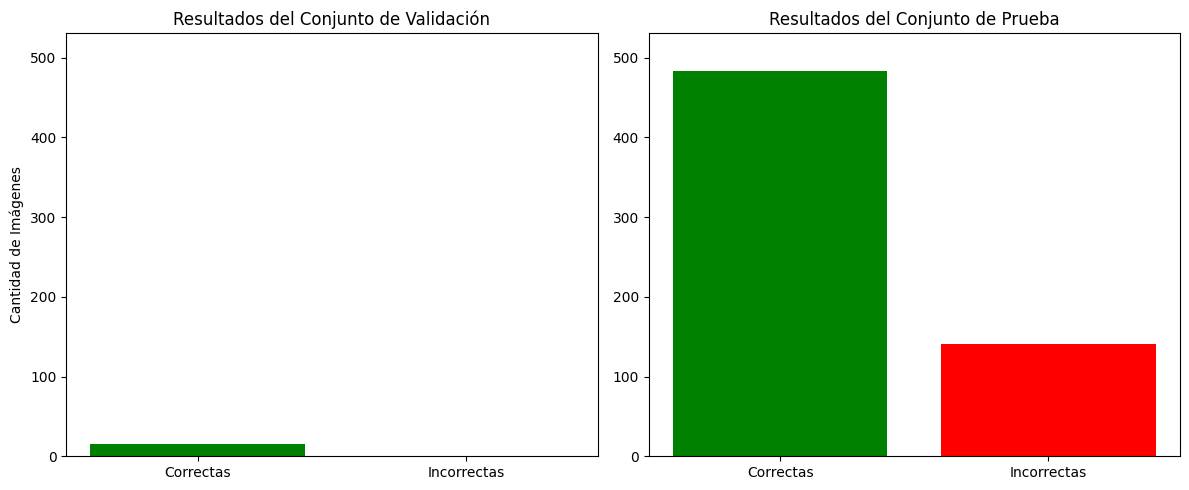

In [ ]:
# Calcular valores para la matriz de confusión del conjunto de validación
tp_val = val_predictions.filter("prediction = 1 AND label = 1").count()  # Verdaderos Positivos
tn_val = val_predictions.filter("prediction = 0 AND label = 0").count()  # Verdaderos Negativos
fp_val = val_predictions.filter("prediction = 1 AND label = 0").count()  # Falsos Positivos
fn_val = val_predictions.filter("prediction = 0 AND label = 1").count()  # Falsos Negativos

# Calcular valores para la matriz de confusión del conjunto de prueba
tp_test = test_predictions.filter("prediction = 1 AND label = 1").count()  # Verdaderos Positivos
tn_test = test_predictions.filter("prediction = 0 AND label = 0").count()  # Verdaderos Negativos
fp_test = test_predictions.filter("prediction = 1 AND label = 0").count()  # Falsos Positivos
fn_test = test_predictions.filter("prediction = 0 AND label = 1").count()  # Falsos Negativos

# Preparar datos para los gráficos
val_correct = tp_val + tn_val
val_incorrect = fp_val + fn_val
test_correct = tp_test + tn_test
test_incorrect = fp_test + fn_test

# Datos para los gráficos
labels = ['Correctas', 'Incorrectas']
val_counts = [val_correct, val_incorrect]
test_counts = [test_correct, test_incorrect]

# Crear subplots para los conjuntos de validación y prueba
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de conjunto de validación
axs[0].bar(labels, val_counts, color=['green', 'red'])
axs[0].set_title('Resultados del Conjunto de Validación')
axs[0].set_ylabel('Cantidad de Imágenes')
axs[0].set_ylim(0, max(val_counts + test_counts) * 1.1)  # Ajustar límite de y para ambos gráficos

# Gráfico de conjunto de prueba
axs[1].bar(labels, test_counts, color=['green', 'red'])
axs[1].set_title('Resultados del Conjunto de Prueba')
axs[1].set_ylim(0, max(val_counts + test_counts) * 1.1)  # Mismo límite de y para comparación

plt.tight_layout()
plt.show()

Podemos observar que en el conjunto de validación, el modelo obtuvo un rendimiento casi perfecto, con un número muy alto de predicciones correctas y  ninguna incorrecta. Este alto desempeño en validación podría indicar que el modelo ha aprendido muy bien a clasificar los datos de este conjunto. Sin embargo, puede también ser un síntoma de la cantidad y calidad de los datos que se encuentran en el conjunto de validación. De hecho, después de revisar el conjunto de validación me di cuenta que solo tenemos radiografías normales y de neumonía bacterial.

Ahora bie, en el conjunto de prueba, aunque el número de predicciones correctas es alto, hay un número notable de predicciones incorrectas. La disminución en la precisión en el conjunto de prueba sugiere que el modelo no generaliza perfectamente a datos nuevos y desconocidos. Este comportamiento podría indicar que el modelo está sesgado hacia los patrones del conjunto de entrenamiento y no está capturando suficientemente bien la variabilidad presente en el conjunto de prueba.

Justificación en la Distribución de Datos: Recordando la distribución de datos en el conjunto de prueba, observamos un desbalance, especialmente con una menor representación de la clase "Normal" en comparación con "Neumonía Bacterial". Esto podría explicar parte de las predicciones incorrectas, ya que el modelo podría estar sesgado hacia clasificar más imágenes como "Neumonía" (dada su mayor representación en los datos de entrenamiento), afectando la precisión para imágenes normales.

# Resumen General del Modelo

Fortalezas: El modelo muestra una alta precisión en el conjunto de validación y un desempeño decente en el conjunto de prueba, particularmente en la detección de neumonía (altos verdaderos positivos).

Áreas de Mejora: El modelo presenta sobreajuste hacia el conjunto de validación, además de una tasa considerable de falsos positivos. Esto sugiere que podría beneficiarse de técnicas de regularización, data augmentation o ajuste de hiperparámetros para mejorar su capacidad de generalización ya que existe un desbalance de clases claro en el conjunto de entrenamiento.

# Extracción de Características

El siguiente código tiene como propósito extraer características relevantes de imágenes de rayos X de pecho para crear un conjunto de datos tabular. Estas características se almacenan en un archivo CSV, lo que permite analizar y utilizar los datos de manera estructurada para generar visualizaciones de valor en Tableau para entender nuestra base de datos y resultados del modelo.

***Diccionario de variables:***

- Características básicas de la imagen:

image_path: Ruta completa del archivo de la imagen

image_height: Altura de la imagen en píxeles

image_width: Ancho de la imagen en píxeles

file_name: Nombre del archivo de la imagen

- Características de intensidad general:

mean_intensity: Promedio de intensidad de toda la imagen (qué tan brillante/oscura es en general)

std_intensity: Desviación estándar de la intensidad (qué tanta variación hay en los niveles de gris)

median_intensity: Valor medio de intensidad (el valor que divide la distribución en dos partes iguales)

max_intensity: Valor máximo de intensidad (el punto más brillante)

min_intensity: Valor mínimo de intensidad (el punto más oscuro)

intensity_range: Diferencia entre la intensidad máxima y mínima (rango dinámico de la imagen)

- Características por región pulmonar:

left_lung_mean: Intensidad promedio del pulmón izquierdo

right_lung_mean: Intensidad promedio del pulmón derecho

symmetry_ratio: Relación entre la intensidad media del pulmón izquierdo y derecho (un valor cercano a 1 indica simetría)

lung_asymmetry: Valor absoluto de la diferencia entre las medias de ambos pulmones (cuánta asimetría hay)

- Características de textura:

texture_variance: Varianza de la intensidad (indica qué tan homogénea o heterogénea es la imagen)

opacity_area: Proporción del área que muestra opacidades (zonas muy brillantes, típicas en neumonía)

- Características de histograma (distribución de intensidades):

histogram_low: Proporción de píxeles con intensidad baja (<85)

histogram_mid: Proporción de píxeles con intensidad media (85-170)

histogram_high: Proporción de píxeles con intensidad alta (>170)

- Metadata y clasificación:

dataset_type: Indica si la imagen pertenece al conjunto de 'test', 'train' o 'val'

diagnosis: Diagnóstico principal ('NORMAL' o 'PNEUMONIA')

pneumonia_type: Tipo específico de caso ('normal', 'bacterial' o 'viral')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta a la carpeta principal en Google Drive
base_dir = '/content/drive/My Drive/chest_xray/'

import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

def extract_image_features(image_path):
    """
    Extrae características relevantes de una imagen de rayos X.
    """
    # Leer imagen
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
        return None

    # Preprocesamiento básico
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Dividir la imagen en regiones (izquierda/derecha)
    height, width = img.shape
    mid = width // 2
    left_lung = img[:, :mid]
    right_lung = img[:, mid:]

    # Extraer características
    features = {
        'image_path': str(image_path),
        'mean_intensity': np.mean(img),
        'std_intensity': np.std(img),
        'left_lung_mean': np.mean(left_lung),
        'right_lung_mean': np.mean(right_lung),
        'symmetry_ratio': np.mean(left_lung) / np.mean(right_lung),
        'texture_variance': np.var(img),
        'image_height': height,
        'image_width': width,

        # Características de histograma
        'histogram_low': np.sum(img < 85) / (height * width),
        'histogram_mid': np.sum((img >= 85) & (img < 170)) / (height * width),
        'histogram_high': np.sum(img >= 170) / (height * width),

        # Detectar áreas opacas (ajustar umbral según necesidad)
        'opacity_area': np.sum(img > 200) / (height * width),

        # Estadísticas adicionales
        'median_intensity': np.median(img),
        'max_intensity': np.max(img),
        'min_intensity': np.min(img)
    }

    return features

def process_dataset(base_path):
    """
    Procesa todas las imágenes en las carpetas test, train y val y genera un CSV con las características.
    """
    base_path = Path(base_path)
    folders = ['test', 'train', 'val']
    categories = ['NORMAL', 'PNEUMONIA']

    # Lista para almacenar todos los datos
    all_data = []

    # Procesar cada carpeta
    for folder in folders:
        folder_path = base_path / folder

        # Procesar cada categoría
        for category in categories:
            category_path = folder_path / category

            if not category_path.exists():
                print(f"Advertencia: La carpeta {category_path} no existe")
                continue

            # Procesar cada imagen en la categoría
            image_files = list(category_path.glob('*.jpeg')) + list(category_path.glob('*.jpg'))

            print(f"Procesando {len(image_files)} imágenes de {folder}/{category}")

            for img_path in tqdm(image_files):
                features = extract_image_features(img_path)

                if features is not None:
                    # Agregar información adicional
                    features.update({
                        'dataset_type': folder,  # test, train, o val
                        'diagnosis': category,   # NORMAL o PNEUMONIA
                        'file_name': img_path.name
                    })

                    # Si es una imagen de neumonía, determinar el tipo
                    if category == 'PNEUMONIA':
                        features['pneumonia_type'] = 'bacterial' if 'bacteria' in img_path.name.lower() else 'viral'
                    else:
                        features['pneumonia_type'] = 'normal'

                    all_data.append(features)

    # Crear DataFrame
    df = pd.DataFrame(all_data)

    # Agregar algunas características derivadas
    df['lung_asymmetry'] = abs(df['left_lung_mean'] - df['right_lung_mean'])
    df['intensity_range'] = df['max_intensity'] - df['min_intensity']

    # Guardar como CSV
    output_path = base_path / 'xray_features.csv'
    df.to_csv(output_path, index=False)

    print(f"\nProceso completado. Datos guardados en: {output_path}")
    print(f"Total de imágenes procesadas: {len(df)}")
    print("\nResumen de datos:")
    print(df['diagnosis'].value_counts())
    print("\nDistribución por conjunto de datos:")
    print(df.groupby(['dataset_type', 'diagnosis']).size())

    return df

# Procesar el dataset en Google Colab
df = process_dataset(base_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Procesando 234 imágenes de test/NORMAL


100%|██████████| 234/234 [00:18<00:00, 12.95it/s]


Procesando 390 imágenes de test/PNEUMONIA


100%|██████████| 390/390 [00:13<00:00, 28.54it/s]


Procesando 1341 imágenes de train/NORMAL


100%|██████████| 1341/1341 [02:04<00:00, 10.73it/s]


Procesando 3875 imágenes de train/PNEUMONIA


100%|██████████| 3875/3875 [03:08<00:00, 20.52it/s]


Procesando 8 imágenes de val/NORMAL


100%|██████████| 8/8 [00:00<00:00, 20.25it/s]


Procesando 8 imágenes de val/PNEUMONIA


100%|██████████| 8/8 [00:00<00:00, 31.89it/s]



Proceso completado. Datos guardados en: /content/drive/My Drive/chest_xray/xray_features.csv
Total de imágenes procesadas: 5856

Resumen de datos:
diagnosis
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

Distribución por conjunto de datos:
dataset_type  diagnosis
test          NORMAL        234
              PNEUMONIA     390
train         NORMAL       1341
              PNEUMONIA    3875
val           NORMAL          8
              PNEUMONIA       8
dtype: int64


# Gráficas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


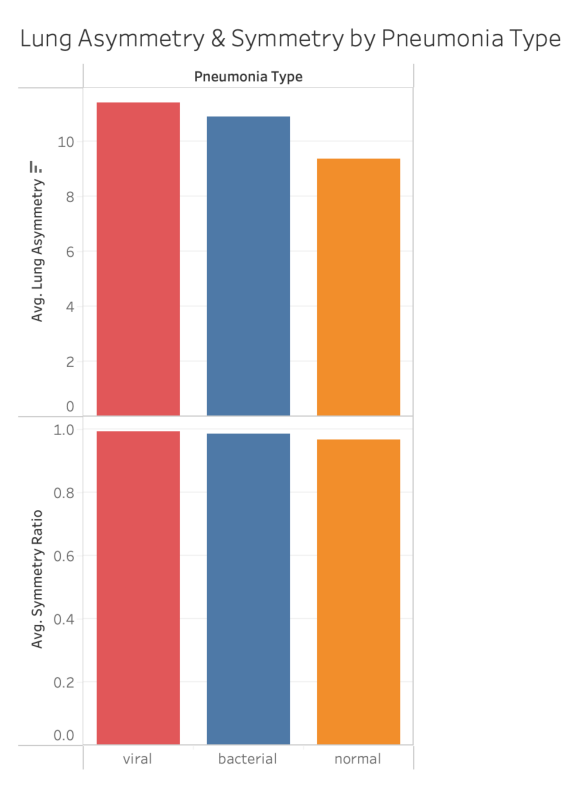

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/drive/MyDrive/imagenes_xray/1.png')

# Ajusta el tamaño de la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

La asimetría pulmonar promedio es mayor en los casos de neumonía viral y bacteriana en comparación con los casos normales. Entre los tipos de neumonía, la asimetría es ligeramente mayor en la neumonía viral que en la bacteriana.
Una mayor asimetría pulmonar puede indicar la presencia de opacidades o variaciones en la estructura pulmonar, que son comunes en casos de neumonía. La métrica de asimetría podría ser particularmente útil en la detección de neumonía, ya que tiende a ser más alta en los casos afectados.

La relación de simetría promedio está cerca de 1 para todos los tipos, incluyendo las imágenes normales, pero es ligeramente menor en las imágenes normales. Un valor cercano a 1 indica que, en general, hay una simetría entre los pulmones, incluso en presencia de neumonía.

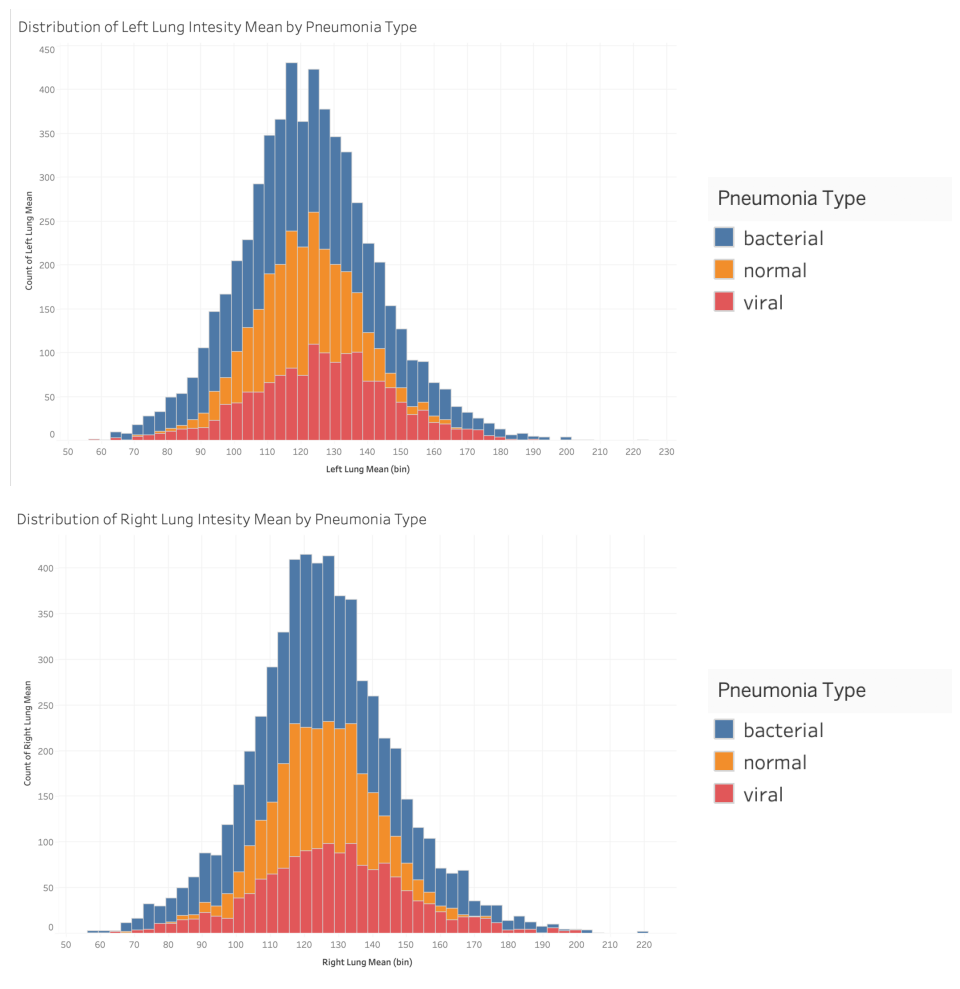

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec

# Crear figura
fig = plt.figure(figsize=(10, 10))

# Crear grid con diferentes proporciones
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])  # Proporción 3:1

# Crear subplots
ax1 = plt.subplot(gs[0])  # Primera imagen (más grande)
ax2 = plt.subplot(gs[1])  # Leyenda (más pequeña)
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

img1 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/2.png')
img2 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/legend.png')
img3 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/3.png')
img4 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/legend.png')

ax1.imshow(img1)
ax1.axis('off')
ax2.imshow(img2)
ax2.axis('off')
ax3.imshow(img3)
ax3.axis('off')
ax4.imshow(img4)
ax4.axis('off')
plt.tight_layout()
plt.show()

En las gráficas de arriba, el eje X epresenta los valores de intensidad promedio de los píxeles en el pulmón izquierdo o derecho, agrupados en intervalos (bins). Cada intervalo en el eje X corresponde a un rango específico de intensidad media en una imagen de rayos X. En cambio, el eje Y indica el número de imágenes (frecuencia) en cada intervalo de intensidad. En otras palabras, muestra cuántas imágenes de cada tipo (bacterial, viral o normal) tienen una intensidad media que cae dentro de cada rango específico del eje X.

Casos de Neumonía Bacteriana (azul): Tiene el mayor conteo en la mayoría de los intervalos de intensidad media. Esto sugiere que hay un mayor número de imágenes etiquetadas como neumonía bacteriana en el conjunto de datos, lo cual se refleja en las alturas más grandes de las barras azules en casi todo el rango de intensidades.

Casos Normales (naranja): La distribución de los casos normales es similar en forma a la distribución de neumonía bacteriana, pero el conteo es menor. Los valores de intensidad media tienden a concentrarse en el rango de 110-140.

Casos de Neumonía Viral (rojo): La intensidad promedio en los casos de neumonía viral tiende a estar en los rangos parecidos de intensidad (110-150), con una menor dispersión en los extremos. También, es de utilidad resaltar que la cantidad de imágenes que tenemos de neumonía viral es muy bajo y el brillo en la imagen se dispersa más, esta puede ser la razón por la cual nuestro modelo confunde las imágenes de pulmones normales con imágenes de pulmones con neumonía.

Total de imágenes:

bacterial    2780

normal       1583

viral        1493

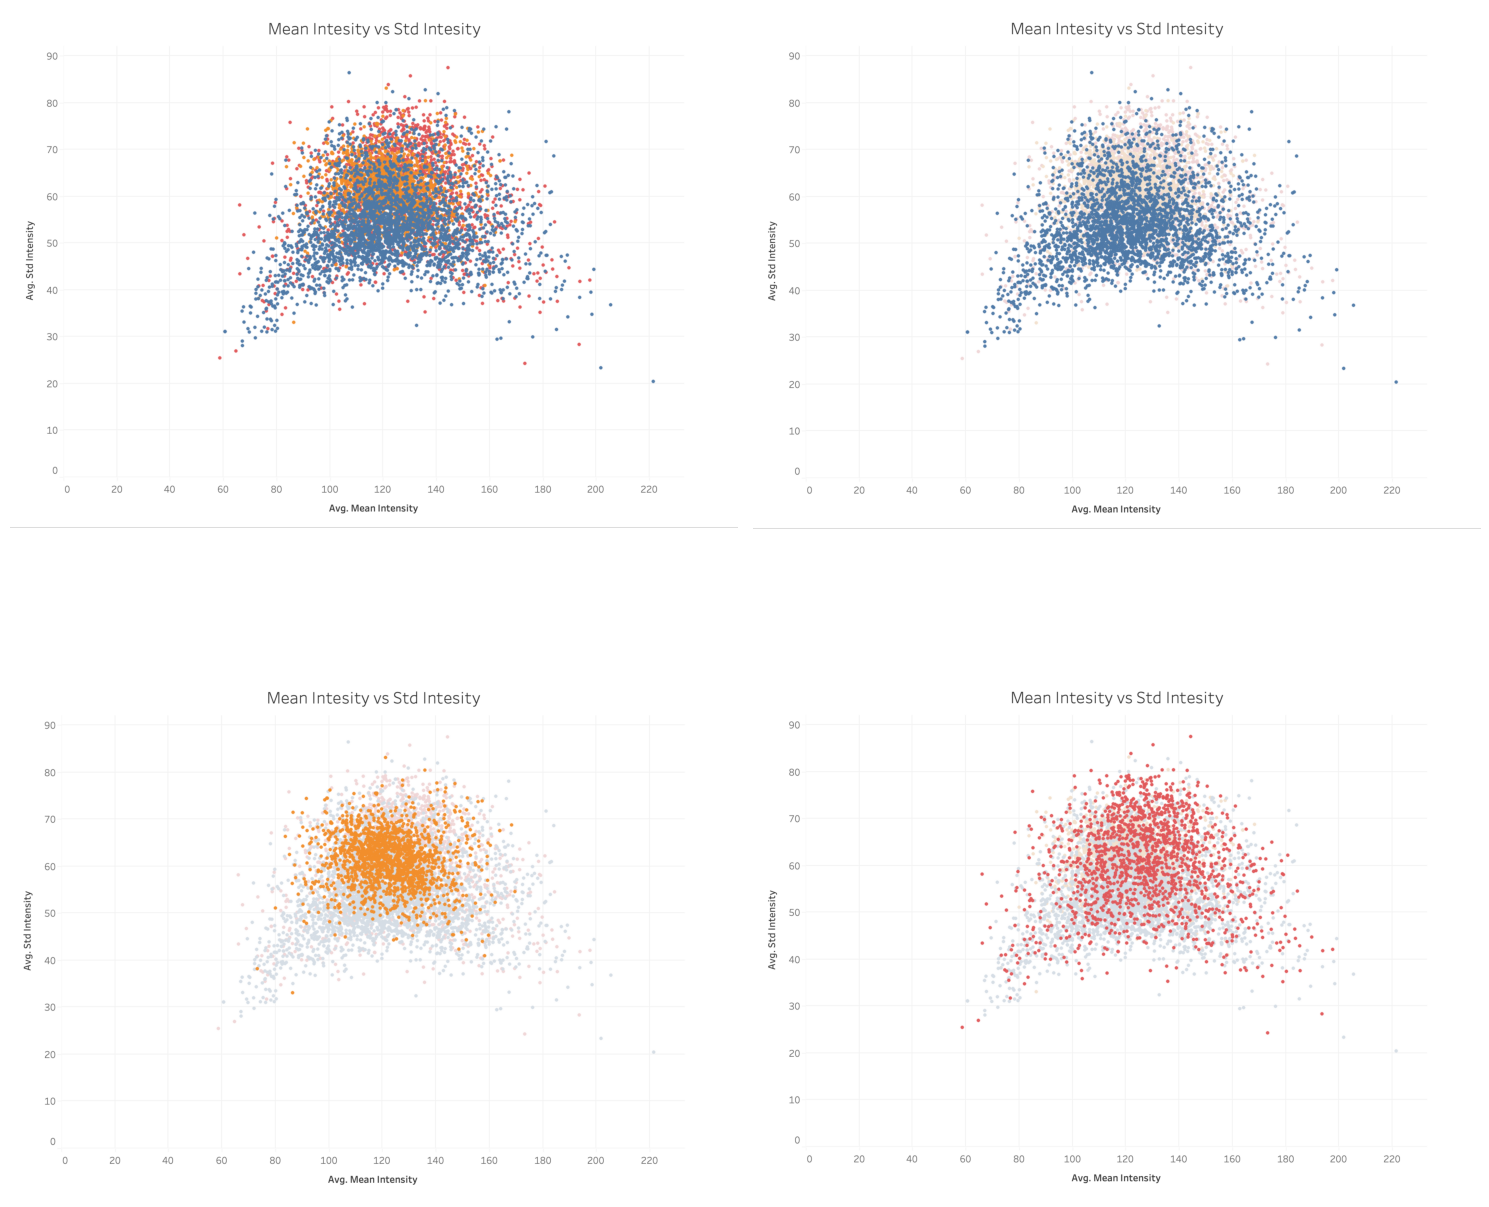

In [ ]:
# Crear figura
fig = plt.figure(figsize=(15, 15))

# Crear grid con diferentes proporciones
gs = gridspec.GridSpec(2, 2)

# Crear subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

img1 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/4.png')
img2 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/5.png')
img3 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/6.png')
img4 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/7.png')

ax1.imshow(img1)
ax1.axis('off')
ax2.imshow(img2)
ax2.axis('off')
ax3.imshow(img3)
ax3.axis('off')
ax4.imshow(img4)
ax4.axis('off')
plt.tight_layout()
plt.show()

Este gráfico muestra la distribución de las tres clases (bacteriana en azul, viral en rojo, y normal en naranja) en función de su intensidad media y su desviación estándar.

Neumonía Bacteriana (Azul): Los puntos están esparcidos de manera uniforme en el área central del gráfico, lo que sugiere una mayor variabilidad tanto en la media como en la desviación estándar de intensidad en estas imágenes.

Neumonía Viral (Rojo): También se encuentra distribuida en el área central, pero hay una ligera tendencia a concentrarse en desviaciones estándar más bajas que las imágenes bacterianas pero más altas que las imáganes normales.

Imágenes Normales (Naranja): Las imágenes normales están principalmente en el centro del gráfico, con una distribución similar a la de la neumonía bacteriana y viral pero sin tanta variabilidad en sus datos.

Esta gráfica es informativa para visualizar la distribución general de las imágenes de rayos X en términos de media y desviación estándar de intensidad, pero tiene limitaciones para la clasificación. La superposición de las tres categorías indica que estos dos parámetros no son suficientes para separar efectivamente los tipos de neumonía o distinguir los casos normales. Esto sugiere que otras características, posiblemente texturales o basadas en patrones más complejos, serían necesarias para mejorar la clasificación de nuestro modelo.

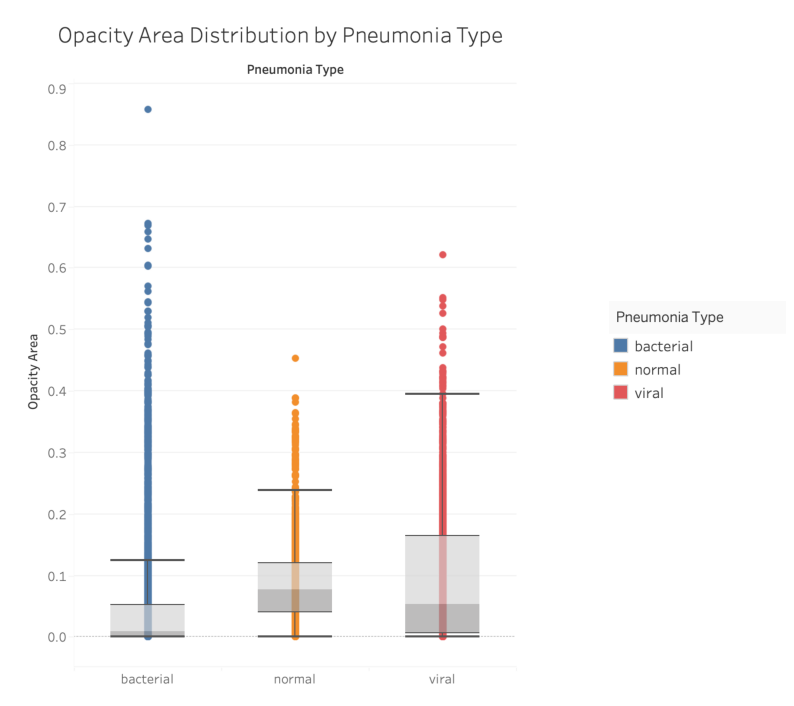

In [ ]:
# Crear figura
fig = plt.figure(figsize=(10, 10))

# Crear grid con diferentes proporciones
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Proporción 3:1

# Crear subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


img1 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/8.png')
img2 = mpimg.imread('/content/drive/MyDrive/imagenes_xray/legend.png')

ax1.imshow(img1)
ax1.axis('off')
ax2.imshow(img2)
ax2.axis('off')
plt.show()

El eje Y representa el Área de Opacidad como una proporción de la imagen total. Valores altos en esta métrica indican que una gran parte de la imagen muestra áreas opacas, típicas de ciertas patologías pulmonares. El valor está normalizado entre 0 y 1 (es una proporción). 0 significaría que no hay áreas muy brillantes y 1 significaría que toda la imagen es muy brillante. Por ejemplo, un valor de 0.15 significa que 15% del área de la imagen tiene píxeles muy brillantes.

Los casos de neumonía (especialmente la bacteriana) presentan un área de opacidad significativamente mayor y más variable en comparación con los casos normales. Esto es consistente con el hecho de que la neumonía suele producir áreas de opacidad en los pulmones, visibles como zonas más brillantes en las radiografías, esto podría reflejar una tendencia a formar mayores opacidades en comparación con la neumonía viral. Como vimos en la gráfica de brillo en los pulmones, esta puede ser la razón por la cual el modelo no generaliza las imágenes normales y la categoriza como neumonía. Una buena practica y posible mejora del modelo es darle más datos o aumentaciones de las impaégenes normales o de neumonía viral para ver si el modelo generaliza mejor y no predice tantos negativos positivos.

Los casos normales tienen una distribución mucho más estrecha y concentrada cerca de 0, lo que es lógico, ya que en ausencia de neumonía no debería haber grandes áreas opacas en los pulmones.

# Referencias

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download